In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from keras_preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from sklearn.preprocessing import MultiLabelBinarizer
import os
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
import pickle
import time
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from keras import Model
import fnmatch

In [3]:
path='../input/plant-pathology-2021-fgvc8/'
path_2='../input/plant-pathology-2021-fgvc8/train_images'
train_data=pd.read_csv(path +"train.csv")
train_data['f_names']=train_data['image'].apply( lambda string: string.split('.jpg')[0] )
train_data['file_names']=path_2 + '/' + train_data['image']
train_data.head()

,image,labels,f_names,file_names
0,800113bb65efe69e.jpg,healthy,800113bb65efe69e,../input/plant-pathology-2021-fgvc8/train_imag...
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,8002cb321f8bfcdf,../input/plant-pathology-2021-fgvc8/train_imag...
2,80070f7fb5e2ccaa.jpg,scab,80070f7fb5e2ccaa,../input/plant-pathology-2021-fgvc8/train_imag...
3,80077517781fb94f.jpg,scab,80077517781fb94f,../input/plant-pathology-2021-fgvc8/train_imag...
4,800cbf0ff87721f8.jpg,complex,800cbf0ff87721f8,../input/plant-pathology-2021-fgvc8/train_imag...


In [4]:
new_folder='./resized_doorknob'
os.mkdir(new_folder)

In [5]:
# f='../input/plant-pathology-2021-fgvc8/train_images/800113bb65efe69e.jpg'
# k=f.split('/')[4].split('.jpg')[0]
# i=train_data.loc[train_data['file_names']==f]['f_names'][0]
# print(k)
# print len(fnmatch.filter(os.listdir(dirpath), '*.txt'))

In [6]:
for file in train_data['file_names']:
    #print(file)
    img=cv2.imread(str(file))
    #plt.imshow(img)
    img_resize=cv2.resize(img,(256,256))
    image_name=file.split('/')[4].split('.jpg')[0]
    #print(image_name)
    file_name=new_folder+'/'+image_name+'.jpg'
    #print(file_name)
    cv2.imwrite(file_name,img_resize)

In [7]:
print(len(fnmatch.filter(os.listdir(new_folder), '*.jpg')))

18632


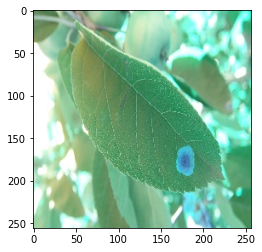

In [8]:
import shutil, random
filenames = random.sample(os.listdir(new_folder), 20)
for fname in filenames:
    srcpath = os.path.join(new_folder, fname)
    img=cv2.imread(srcpath)
    plt.imshow(img)

In [9]:
def encode_dataset(data):
    mlb = MultiLabelBinarizer().fit(data.labels.apply(lambda x : x.split()))
    labels = pd.DataFrame(mlb.transform(data.labels.apply(lambda x : x.split())), columns = mlb.classes_)
    encoded_data = pd.concat([data['image'], labels], axis=1)
    return encoded_data

In [10]:
def image_augmentation(image):
    image = tf.image.random_flip_left_right(image, seed=SEED)
    image = tf.image.random_flip_up_down(image, seed=SEED)
    
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32, seed=SEED)
    image = tf.image.rot90(image, k=k)
    
    image = tf.image.random_hue(image, .1, seed=SEED)
    image = tf.image.random_saturation(image, .8, 1.2, seed=SEED)
    image = tf.image.random_contrast(image, .8, 1.2, seed=SEED)
    image = tf.image.random_brightness(image, .1, seed=SEED)
    return image

In [11]:
image_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,preprocessing_function=image_augmentation,
                                                              validation_split=0.1)


In [12]:
labels=encode_dataset(train_data)
print(labels.head())
input_size=(256,256)
input_shape=(256,256,3)
batch_size=16
SEED=42

                  image  complex  frog_eye_leaf_spot  healthy  powdery_mildew  \
0  800113bb65efe69e.jpg        0                   0        1               0   
1  8002cb321f8bfcdf.jpg        1                   1        0               0   
2  80070f7fb5e2ccaa.jpg        0                   0        0               0   
3  80077517781fb94f.jpg        0                   0        0               0   
4  800cbf0ff87721f8.jpg        1                   0        0               0   

   rust  scab  
0     0     0  
1     0     1  
2     0     1  
3     0     1  
4     0     0  


In [13]:
train_gen=image_datagen.flow_from_dataframe(labels,
                                             directory=new_folder,
                                             x_col='image',
                                             y_col=labels.columns.tolist()[1:],
                                             class_mode='raw',
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             subset='training',
                                             shuffle=True, 
                                             target_size=input_size)
val_gen=image_datagen.flow_from_dataframe(labels,
                                             directory=new_folder,
                                             x_col='image',
                                             y_col=labels.columns.tolist()[1:],
                                             class_mode='raw',
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             subset='validation',
                                             shuffle=True, 
                                             target_size=input_size)

Found 16769 validated image filenames.
Found 1863 validated image filenames.


In [14]:
 base_model = tf.keras.applications.ResNet50(weights='imagenet',pooling='avg',include_top=False, input_shape=input_shape)
def create_model():
    x=base_model.output
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Dense(64,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.3)(x)
    x=tf.keras.layers.Dense(32,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.3)(x)
    predictions = tf.keras.layers.Dense(len(labels.columns.tolist()[1:]), activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

94773248/94765736 [==============================] - 3s 0us/step


In [15]:
metrics = [tfa.metrics.F1Score(num_classes =len(labels.columns.tolist()[1:]),average = "macro",name = "f1_score")]

In [16]:
def initiate_callbacks():
    lr_reduction =tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_f1_score',mode='max',factor=0.1,patience=3,verbose=0)

    cpk_path = './best_model.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cpk_path,monitor= 'val_f1_score',mode='max',save_best_only=True,verbose=1)

    earlystop = tf.keras.callbacks.EarlyStopping(monitor= 'val_f1_score',mode='max',patience=10,verbose=1)

    callbacks = [checkpoint, earlystop]
    return callbacks

In [17]:
initial_model=create_model()
initial_model.summary()
initial_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=metrics)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
 history = initial_model.fit(train_gen,validation_data=val_gen,epochs=10,callbacks=initiate_callbacks(),verbose=1)

Epoch 1/10
1049/1049 [==============================] - 295s 269ms/step - loss: 0.5443 - f1_score: 0.2310 - val_loss: 0.4137 - val_f1_score: 0.2907

Epoch 00001: val_f1_score improved from -inf to 0.29075, saving model to ./best_model.h5
Epoch 2/10
1049/1049 [==============================] - 281s 268ms/step - loss: 0.3882 - f1_score: 0.3589 - val_loss: 0.8695 - val_f1_score: 0.1623

Epoch 00002: val_f1_score did not improve from 0.29075
Epoch 3/10
1049/1049 [==============================] - 280s 267ms/step - loss: 0.3521 - f1_score: 0.4542 - val_loss: 0.4083 - val_f1_score: 0.3284

Epoch 00003: val_f1_score improved from 0.29075 to 0.32836, saving model to ./best_model.h5
Epoch 4/10
1049/1049 [==============================] - 279s 266ms/step - loss: 0.3163 - f1_score: 0.5332 - val_loss: 0.4244 - val_f1_score: 0.4406

Epoch 00004: val_f1_score improved from 0.32836 to 0.44057, saving model to ./best_model.h5
Epoch 5/10
1049/1049 [==============================] - 281s 267ms/step - lo

In [19]:
def load_best_model():
    best_m = tf.keras.models.load_model(
        "./best_model.h5"
    )
    return best_m

In [20]:
primary_tune_model = load_best_model()

In [21]:
optimizer_ft = tf.keras.optimizers.Adam(lr=1e-5)
Loss_ft=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
base_model.trainable=True
primary_tune_model.compile(optimizer=optimizer_ft,loss=Loss_ft,metrics=metrics)
history_ft = primary_tune_model.fit(train_gen,validation_data=val_gen,epochs=3,callbacks=initiate_callbacks(),verbose=1)

Epoch 1/3
1049/1049 [==============================] - 287s 268ms/step - loss: 0.2415 - f1_score: 0.6579 - val_loss: 0.1844 - val_f1_score: 0.7578

Epoch 00001: val_f1_score improved from -inf to 0.75776, saving model to ./best_model.h5
Epoch 2/3
1049/1049 [==============================] - 278s 265ms/step - loss: 0.2307 - f1_score: 0.7104 - val_loss: 0.1811 - val_f1_score: 0.7719

Epoch 00002: val_f1_score improved from 0.75776 to 0.77193, saving model to ./best_model.h5
Epoch 3/3
1049/1049 [==============================] - 278s 265ms/step - loss: 0.2273 - f1_score: 0.6961 - val_loss: 0.1736 - val_f1_score: 0.7736

Epoch 00003: val_f1_score improved from 0.77193 to 0.77357, saving model to ./best_model.h5


In [23]:
opt_model=load_best_model()
submission=pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')
submission.head()

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [24]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
test_generator =  test_datagen.flow_from_dataframe(
    submission,
    directory="../input/plant-pathology-2021-fgvc8/test_images",
    x_col='image',
    y_col='labels',
    target_size=input_size,
    color_mode="rgb",
    batch_size=1,
    shuffle=False,
    seed=SEED,
    subset=None
)

Found 3 validated image filenames belonging to 1 classes.


In [25]:
predicts = opt_model.predict(test_generator)

In [26]:
verdict = (predicts>0.40)
label = labels.columns.tolist()[1:]
answer = []
for i in range(verdict.shape[0]):
    tmp = []
    for j, c in enumerate(label):
        if verdict[i, j]:
            tmp.append(c)
    answer.append(tmp)
    
answer = [' '.join(t) for t in answer]

In [27]:
submission['labels'] = np.array(answer)
submission.head()

,image,labels
0,85f8cb619c66b863.jpg,rust
1,ad8770db05586b59.jpg,complex frog_eye_leaf_spot
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot


In [28]:
shutil.rmtree(new_folder)
os.remove("./best_model.h5")

In [29]:
submission.to_csv('submission.csv', index=False)